# GPR to predict the number of atoms


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter
from sklearn.metrics import r2_score
import sklearn.gaussian_process as gp

In [2]:
df = pd.read_csv('mu_cn10000.csv')


In [3]:
def GPR_get_CN(features, labels, percent_test):
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=percent_test, random_state = 42)
    # Import the model we are using
    kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
    gpr = model.fit(train_features, train_labels)
    params = model.kernel_.get_params()
    pred_labels, std = model.predict(test_features, return_std=True)
    MSE = ((pred_labels-test_labels)**2).mean()
    RMSE = MSE**(1/2)
    print('MSE = ', MSE)
    print('RMSE =', RMSE)
    rSquare = r2_score(test_labels, pred_labels)
    print('R Squared Error:', rSquare)
    return (RMSE, rSquare)

In [5]:
def xanes_derivatives_noise(mu_df, noise_std, dx=0.80808080808):
    '''
    xanes_derivatives_noise will add noise and then smooth the noise using a savgol filter
    Neural network is trained on averaged spectra only. The spectra are split into a training set and 
    testing set with a ratio of noise. 
    
    next it calculates and returns the first and second derivative of a series of XANES spectra.
    Inputs:
        mu_df = Pandas dataframe of averaged XANES spectra absorption values.
        dx = distance between uniformly distributed energy values in XANES spectra. Defaulted to value provided in data.
        noise, the standard deviation of the noise
    '''
    for nums in range(len(mu_df)):
        if nums == 0:
            pass
    
    X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
    list = X.columns.tolist()

    X.columns = range(X.shape[1])

    #I might need to make a random seed here
    noise = np.random.normal(0, noise_std, [10000,100])
    X_noise = X + noise
    X_noise.columns = list

    for index, row in X_noise.iterrows():
        savgol_filter(row, 11, 3)

    for index, row in X_noise.iterrows():
        savgol_filter(row, 5, 2)    
    
    

    dmu1 = np.zeros([len(mu_df), len(mu_df.columns)])
    dmu2 = np.zeros([len(mu_df), len(mu_df.columns)])

    if len(mu_df.columns) == 1000:
        dx =0.1*dx

    for i in range(len(mu_df)):
        for j in range(len(mu_df.columns)):
            if j == len(mu_df.columns)-1:
                pass
            else:
                dmu1[i, j] = (mu_df.iloc[i, j+1] - mu_df.iloc[i, j]) / dx

    for i_ in range(len(mu_df)):
        for j_ in range(len(mu_df.columns)):
            if j_ == len(mu_df.columns)-1:
                pass
            else:
                dmu2[i_, j_] = (dmu1[i_, j_+1] - dmu1[i_, j_]) / dx

    return dmu1, dmu2

In [6]:
#This is actually where I need to add the noise
def raw_spectra(df):

    features=np.array(df.loc[:,'Mu1':'Mu100'])
    
    return features

In [7]:
def one_demension_get_N_evenly_spaced_elements(arr, numElems):
    '''
    return nd.array
    '''
    idx = np.round(np.linspace(0, len(arr) - 1, numElems)).astype(int)
    return arr[idx]

In [8]:
def ndArray_get_N_evely_spaced_elements(after_smooth, numElems):
    ndArray_evenly_spaced=np.array([])
    for arr in after_smooth:
        a_row_evenly_spaced=one_demension_get_N_evenly_spaced_elements(arr, numElems)
        print(a_row_evenly_spaced)
        #ndArray_evenly_spaced=np.concatenate((ndArray_evenly_spaced, [a_row_evenly_spaced]),axis=0)
        ndArray_evenly_spaced  = np.append(ndArray_evenly_spaced, a_row_evenly_spaced, axis=0)
    return ndArray_evenly_spaced.reshape(len(after_smooth),numElems)

In [9]:
def noise_vs_error (size, test_percent, noise_list, df):
    spectrum_data = []
    dmu1_data = []
    dmu2_data = []
    dmu_both_data = []
    for entry in noise_list:
        df_sample = df.sample(size, random_state=26)
        raw_df_sample = raw_spectra(df_sample)
        dmu1, dmu2 =xanes_derivatives_noise(pd.DataFrame(raw_df_sample), entry)
        dmu_both= np.concatenate((dmu1,dmu2),axis=1)
        print('noise STD =', entry)
        print('spectrum')
        spectrum_data.append(GPR_get_CN(raw_df_sample, np.array(df_sample['CN']), test_percent))
        print('dmu1')
        dmu1_data.append(GPR_get_CN(dmu1, np.array(df_sample['CN']), test_percent))        
        print('dmu2')
        dmu2_data.append(GPR_get_CN(dmu2, np.array(df_sample['CN']), test_percent))
        print('dmu_both')
        dmu_both_data.append(GPR_get_CN(dmu_both, np.array(df_sample['CN']), test_percent))

    return (spectrum_data, dmu1_data, dmu2_data, dmu_both_data)

In [12]:
size = 10000
test_percent = 0.5
noise_list = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
noise_vs_error(size, test_percent, noise_list, df)

noise STD = 0
spectrum
MSE =  0.0011700555213040112
RMSE = 0.034206074333428135
R Squared Error: 0.9937946840886143
dmu1
MSE =  0.0007573455569400981
RMSE = 0.02751991200821867
R Squared Error: 0.9959834654430244
dmu2
MSE =  0.0008496866972756617
RMSE = 0.029149385881621276
R Squared Error: 0.9954937400095157
dmu_both
MSE =  0.0007145951803213454
RMSE = 0.026731913143681754
R Squared Error: 0.9962101893782735
noise STD = 0.005
spectrum
MSE =  0.0011700531086012128
RMSE = 0.0342060390662411
R Squared Error: 0.9937946968842319
dmu1
MSE =  0.0007573446158444514
RMSE = 0.02751989490976394
R Squared Error: 0.995983470434066
dmu2
MSE =  0.0008496868229976432
RMSE = 0.029149388038132863
R Squared Error: 0.9954937393427572
dmu_both
MSE =  0.0007145951845414702
RMSE = 0.026731913222615963
R Squared Error: 0.9962101893558925
noise STD = 0.01
spectrum
MSE =  0.0011700531086012128
RMSE = 0.0342060390662411
R Squared Error: 0.9937946968842319
dmu1
MSE =  0.0007573446154767348
RMSE = 0.0275198949030

/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.26204035e+00,  1.27068136e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


MSE =  0.0007573452252954398
RMSE = 0.02751990598267806
R Squared Error: 0.995983467201881
dmu2
MSE =  0.0008496866969697731
RMSE = 0.029149385876374362
R Squared Error: 0.9954937400111381
dmu_both


/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.12909525e+00,  4.71307819e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


MSE =  0.0007145953874601722
RMSE = 0.02673191701805488
R Squared Error: 0.9962101882797259
noise STD = 0.02
spectrum
MSE =  0.0011700531086012128
RMSE = 0.0342060390662411
R Squared Error: 0.9937946968842319
dmu1
MSE =  0.000757344948019951
RMSE = 0.027519900944951655
R Squared Error: 0.9959834686723942
dmu2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.47042856e+00,  1.94693955e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.47044616e+00,  6.25009549e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


MSE =  0.0008496871228637433
RMSE = 0.02914939318174125
R Squared Error: 0.9954937377524361
dmu_both
MSE =  0.000714595164812164
RMSE = 0.026731912853594372
R Squared Error: 0.9962101894605255
noise STD = 0.025
spectrum
MSE =  0.0011700576373631585
RMSE = 0.034206105264457665
R Squared Error: 0.9937946728662277
dmu1
MSE =  0.000757344127130685
RMSE = 0.027519886030481392
R Squared Error: 0.9959834730259288
dmu2
MSE =  0.00084968670142717
RMSE = 0.02914938595283218
R Squared Error: 0.9954937399874986
dmu_both
MSE =  0.0007145951804349042
RMSE = 0.026731913145805784
R Squared Error: 0.9962101893776714
noise STD = 0.03
spectrum
MSE =  0.0011700546439839658
RMSE = 0.03420606150938699
R Squared Error: 0.9937946887414261
dmu1
MSE =  0.0007573446879040383
RMSE = 0.027519896218991056
R Squared Error: 0.9959834700519026
dmu2


KeyboardInterrupt: 

In [13]:
spectrum_data = [(0.034206074333428135, 0.9937946840886143), (0.0342060390662411, 0.9937946968842319), (0.0342060390662411, 0.9937946968842319), (0.03420607154219427, 0.9937946851013284), (0.0342060390662411, 0.9937946968842319), (0.034206105264457665, 0.9937946728662277)]
dmu1_data = [(0.02751991200821867, 0.9959834654430244), (0.02751989490976394, 0.995983470434066), (0.02751989490308302, 0.9959834704360162), (0.02751990598267806, 0.995983467201881), (0.027519900944951655, 0.9959834686723942), (0.027519886030481392, 0.9959834730259288)]
dmu2_data = [(0.029149385881621276, 0.9954937400095157), (0.029149388038132863, 0.9954937393427572), (0.029149385832786683, 0.9954937400246147), (0.9029149385876374362, 0.9954937400111381), (0.02914939318174125, 0.9954937377524361), (0.02914938595283218, 0.9954937399874986)]
dmu_both_data = [(0.026731913143681754, 0.9962101893782735), (0.026731913222615963, 0.9962101893558925), (0.02673191334467955, 0.9962101893212822), (0.02673191701805488, 0.9962101882797259), (0.026731912853594372, 0.9962101894605255), (0.026731913145805784, 0.9962101893776714)]

In [14]:
noise_list = [0, 0.005, 0.01, 0.015, 0.02, 0.025]

In [15]:
spectrum_RMSE = []
spectrum_R2 = []
for entry in spectrum_data:
    spectrum_RMSE.append(entry[0])
    spectrum_R2.append(entry[1])
dmu1_RMSE = []
dmu1_R2 = []
for entry in dmu1_data:
    dmu1_RMSE.append(entry[0])
    dmu1_R2.append(entry[1])
dmu2_RMSE = []
dmu2_R2 = []
for entry in dmu2_data:
    dmu2_RMSE.append(entry[0])
    dmu2_R2.append(entry[1])
dmu_both_RMSE = []
dmu_both_R2 = []
for entry in dmu_both_data:
    dmu_both_RMSE.append(entry[0])
    dmu_both_R2.append(entry[1])

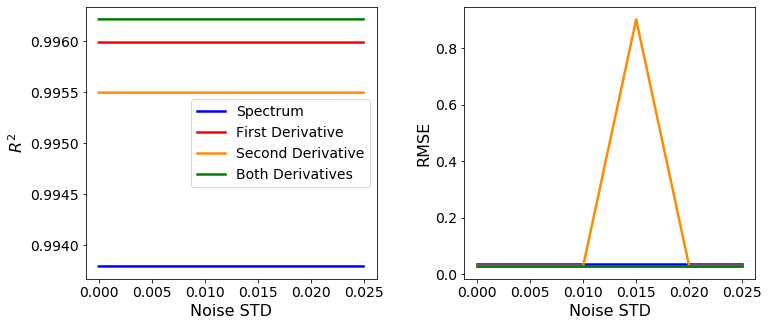

In [16]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(noise_list, spectrum_R2, c='blue', lw=2.5, label='Spectrum')
ax1.plot(noise_list, dmu1_R2, c='red', lw=2.5, label='First Derivative')
ax1.plot(noise_list, dmu2_R2, c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(noise_list, dmu_both_R2, c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Noise STD', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(noise_list, spectrum_RMSE, c='blue', lw=2.5)
ax2.plot(noise_list, dmu1_RMSE, c='red', lw=2.5)
ax2.plot(noise_list, dmu2_RMSE, c='darkorange', lw=2.5)
ax2.plot(noise_list, dmu_both_RMSE, c='green', lw=2.5)
ax2.set_xlabel('Noise STD', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()